# **GWAS tutorial**

In this Jupyter tutorial you can learn how to generate standarized GWA studies. This tests are implemented as part of the functionality of PyOskar API. Here we will use transformers to access PySpark functionality. These kind of functions depend directly from an Oskar object, and they will return a whole dataframe with the due transformation applied.

First, we need to import the PyOskar and PySpark modules. Second, we need to create an instance of the _Oskar_ object, from which depends a big part of the functionality. Finally, we can load our data in a DataFrame _df_ and we are ready to start playing.

In [1]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

You can use PySpark to print the data from _df_. This is how our testing dataframe looks like, you can see that for this tutorial we are using a small dataset from Illumina Platinum Genomes with 1,000 random variants from chromosome 22:

In [5]:
print("Print first 20 variants:")
df.show()

Print first 20 variants:
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|             id|names|chromosome|   start|     end|reference|alternate|strand|  sv|length| type|hgvs|             studies|          annotation|
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|22:16054454:C:T|   []|        22|16054454|16054454|        C|        T|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16054454, 16...|
|22:16065809:T:C|   []|        22|16065809|16065809|        T|        C|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16065809, 16...|
|22:16077310:T:A|   []|        22|16077310|16077310|        T|        A|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16077310, 16...|
|22:16080499:A:G|   []|        22|16080499|16080499|        A|        G|     +|null|     1|  SNV|  []|[[h

NOTE: With _df.printSchema()_ command you can check the dataset hierarchy and all its fields.

In [6]:
print("Print first 20 variants:")
df.count()

Print first 20 variants:


1000

These GWAS transformers take the poblational information stored in the DataFrame to calculate the corresponding p-values. The user will need to specify a particular study and the phenotype he aims to analyze.

## Chi-squared

Usage:
```python
chiSquare(df[DataFrame], studyId[str], phenotype[str])
```

In [17]:
oskar.chiSquare(df, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value")).show(10)

+---------------+-------------------+
|             id|  ChiSquare p-value|
+---------------+-------------------+
|22:16054454:C:T|0.11583677431831574|
|22:16065809:T:C| 0.8162967146689325|
|22:16077310:T:A| 0.3243241555798487|
|22:16080499:A:G|0.16932729721206297|
|22:16084621:T:C|0.11808572685033702|
|22:16091610:G:T|0.24164568184122925|
|22:16096040:G:A|0.24839711482150617|
|22:16099957:C:T| 0.9283082406877704|
|22:16100462:A:G| 0.8244791006886252|
|22:16105660:G:A| 0.9612450306338958|
+---------------+-------------------+
only showing top 10 rows



## Fisher

Usage:
```python
fisher(df[DataFrame], studyId[str], phenotype[str])
```

In [21]:
oskar.fisher(df, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value")).show(10)

+---------------+-------------------+
|             id|     Fisher p-value|
+---------------+-------------------+
|22:16054454:C:T| 0.2941176470588194|
|22:16065809:T:C| 0.9999999999999629|
|22:16077310:T:A| 0.6444578943924588|
|22:16080499:A:G|0.29575642573744654|
|22:16084621:T:C| 0.2907969639468656|
|22:16091610:G:T| 0.5387700534759321|
|22:16096040:G:A|0.39512983254395534|
|22:16099957:C:T| 0.9999999999999654|
|22:16100462:A:G| 0.9999999999999866|
|22:16105660:G:A| 0.9999999999999954|
+---------------+-------------------+
only showing top 10 rows



# PCA???

## ChiSquare vs Fisher

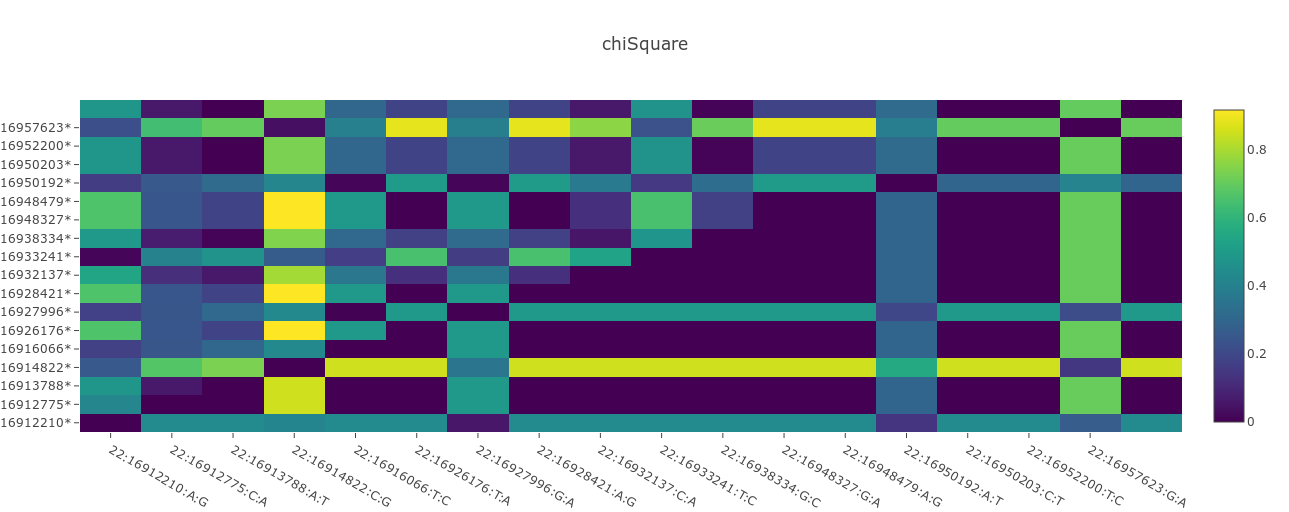

In [16]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import get_plotlyjs, init_notebook_mode

init_notebook_mode(connected = True)

SLCdf = df.filter(array_contains(genes("annotation"), "SLC9B1P4"))

pandasFisher = oskar.fisher(SLCdf, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value").alias("fisher")).toPandas()
pandasChiSquare = oskar.chiSquare(SLCdf, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value").alias("chiSquare")).toPandas()

labels = pandasFisher["id"].tolist()
labelsPosition = [i.split(':', 3)[1] + "*" for i in labels]

# dim = len(labels)
# X = np.zeros((dim, dim))
# for i in range(dim):
#     for j in range(dim):
#         X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

dim = len(labels)
X = np.zeros((dim, dim))
for i in range(dim):
    for j in range(i, dim):
        X[i, j] = np.absolute(pandasFisher["fisher"][i] - pandasFisher["fisher"][j])
for i in range(dim):
    for j in range(i, dim):
        X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

trace = go.Heatmap(x = labels, y= labelsPosition, z = X, colorscale = 'Viridis')
fig = go.Figure(data = [trace])
fig['layout'].update({'width':1440, 'height':500, 'title':'chiSquare'})
py.iplot(fig, filename = 'annotated_heatmap_color')

In [1]:
# import numpy as np
# import plotly.offline as py
# import plotly.figure_factory as ff
# from plotly.offline import get_plotlyjs, init_notebook_mode

# init_notebook_mode(connected=True)

# dfSLC = statsDF.filter(array_contains(genes("annotation"), "SLC9B1P4"))

# pandasFisher = oskar.fisher(dfSLC, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value").alias("fisher")).toPandas()
# pandasChiSquare = oskar.chiSquare(dfSLC, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value").alias("chiSquare")).toPandas()

# labels=pandasFisher["id"].tolist()

# dim = len(labels)
# X = np.zeros((dim, dim))
# for i in range(dim):
#     for j in range(i, dim):
#         X[i, j] = np.absolute(pandasFisher["fisher"][i] - pandasFisher["fisher"][j])
# for i in range(dim):
#     for j in range(i, dim):
#         X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

# fig = ff.create_dendrogram(X, labels=labels, color_threshold=1)
# fig['layout'].update({'width':1440, 'height':500, 'showlegend':True, "title":"chiSquare vs fisher"})
# py.iplot(fig, filename='dendrogram')